# Random circuit simulation

In this notebook we perform simulation of random checkerboard quantum circuits of variying depths. The aim is to track how fidelity decays for a fixed maximum bond dimension of a MPS.

In [1]:
import numpy as np
from tqdm import tqdm
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
from mdopt.utils.utils import create_random_mpo, svd
from mdopt.mps.utils import create_simple_product_state
from mdopt.contractor.contractor import mps_mpo_contract

In [2]:
PHYS_DIM = 2

circ_depths = [4, 6, 8, 10, 12, 14, 16, 18, 20]
bond_dims = [8, 10, 12, 14, 16, 18, 20, 22, 24]
num_qubits = [10]

In [3]:
def create_mpo(gate):
    q, r = np.linalg.qr(gate)
    q_shape = q.shape
    r_shape = r.shape
    q = q.reshape((1, q_shape[1], PHYS_DIM, PHYS_DIM))
    r = r.reshape((r_shape[0], 1, PHYS_DIM, PHYS_DIM))
    return [q, r]


def create_mpo_from_layer(layer):
    mpo = []
    for _, gate in enumerate(layer):
        mpo += create_mpo(gate)
    return mpo

In [4]:
tails = {}
for NUM_QUBITS in num_qubits:
    for BOND_DIM in bond_dims:
        for NUM_LAYERS_CIRC in tqdm(circ_depths):

            state = create_simple_product_state(
                num_sites=NUM_QUBITS,
                phys_dim=PHYS_DIM,
                which="0",
                form="Explicit",
            )
            state.tolerance = np.inf

            tails_iter = []

            for k in range(NUM_LAYERS_CIRC):
                layer = unitary_group.rvs(
                    PHYS_DIM**2, size=NUM_QUBITS // PHYS_DIM - k % 2
                )
                mpo = create_mpo_from_layer(layer)
                state = mps_mpo_contract(
                    mps=state,
                    mpo=mpo,
                    start_site=k % 2,
                    renormalise=True,
                    chi_max=1e4,
                    cut=0,
                    inplace=False,
                    result_to_explicit=True,
                )

                sing_vals = state.singular_values[NUM_QUBITS // 2]

                if len(sing_vals) > BOND_DIM:
                    tails_iter.append(1 - np.sum(np.square(sing_vals[2:])))

            tails[
                "numqubits"
                + str(NUM_QUBITS)
                + "_bonddim"
                + str(BOND_DIM)
                + "_circlayers"
                + str(NUM_LAYERS_CIRC)
            ] = tails_iter

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 25.90it/s]


In [5]:
fidelities_total = {}
for chi in bond_dims:
    fidelities_total[chi] = [
        np.prod(
            tails[
                "numqubits"
                + str(NUM_QUBITS)
                + "_bonddim"
                + str(chi)
                + "_circlayers"
                + str(depth)
            ]
        )
        for depth in circ_depths
    ]

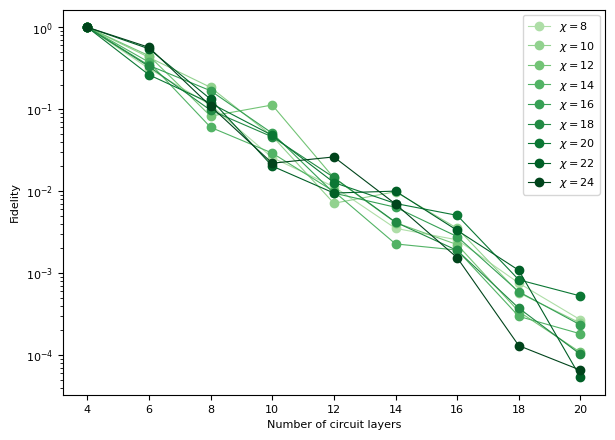

In [6]:
greens = plt.get_cmap("Greens")
plt.figure(figsize=(7, 5))
for qubits in num_qubits:
    for chi in bond_dims:
        try:
            plt.plot(
                circ_depths,
                fidelities_total[chi],
                "-o",
                label="$\chi=$" + str(chi),
                color=greens(chi / max(bond_dims)),
                linewidth=0.8,
                zorder=chi,
            )
        except:
            KeyError
plt.xticks(np.arange(4, 22, 2), fontsize=8)
plt.yticks(fontsize=8)
plt.legend(prop={"size": 8})
plt.ylabel("Fidelity", fontdict={"size": 8})
plt.xlabel("Number of circuit layers", fontdict={"size": 8})
#plt.title(str(qubits) + " qubits", fontsize=9)
plt.yscale("log")
# plt.savefig('mera_'+str(num_qubits)+'.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [10]:
PHYS_DIM = 2

circ_depths = [4, 6, 8, 10, 12, 14, 16, 18, 20]
bond_dims = [8, 10, 12, 14, 16, 18, 20, 22, 24]
num_qubits = [20]

tails = {}
for NUM_QUBITS in num_qubits:
    for BOND_DIM in bond_dims:
        for NUM_LAYERS_CIRC in tqdm(circ_depths):

            state = create_simple_product_state(
                num_sites=NUM_QUBITS,
                phys_dim=PHYS_DIM,
                which="0",
                form="Right-canonical",
            )
            state.tolerance = np.inf

            tails_iter = []

            for k in range(NUM_LAYERS_CIRC):
                layer = unitary_group.rvs(
                    PHYS_DIM**2, size=NUM_QUBITS // PHYS_DIM - k % 2
                )
                #TODO apply two site unitary instead of mpo!
                mpo = create_mpo_from_layer(layer)
                state = mps_mpo_contract(
                    mps=state,
                    mpo=mpo,
                    start_site=k % 2,
                    renormalise=True,
                    chi_max=1e4,
                    cut=0,
                    inplace=False,
                    result_to_explicit=False,
                )

                if state.bond_dimensions[NUM_QUBITS // 2] > BOND_DIM:
                    state, residual_spectrum = state.compress_bond(
                        bond=NUM_QUBITS // 2,
                        chi_max=BOND_DIM,
                        renormalise=True,
                        strategy="svd",
                        return_truncation_error=True,
                    )
                    tails_iter.append(
                        1 - np.sum(np.square(residual_spectrum))
                    )
                
                while max(state.bond_dimensions) > BOND_DIM:
                    state, residual_spectrum = state.compress_bond(
                        bond=np.argmax(state.bond_dimensions),
                        chi_max=BOND_DIM,
                        renormalise=True,
                        strategy="svd",
                        return_truncation_error=True,
                    )
                    # are we sure?
                    tails_iter.append(
                        1 - np.sum(np.square(residual_spectrum))
                    )

            tails[
                "numqubits"
                + str(NUM_QUBITS)
                + "_bonddim"
                + str(BOND_DIM)
                + "_circlayers"
                + str(NUM_LAYERS_CIRC)
            ] = tails_iter

100%|██████████| 9/9 [00:04<00:00,  2.04it/s]


In [11]:
fidelities_total = {}
for chi in bond_dims:
    fidelities_total[chi] = [
        np.prod(
            tails[
                "numqubits"
                + str(NUM_QUBITS)
                + "_bonddim"
                + str(chi)
                + "_circlayers"
                + str(depth)
            ]
        )
        for depth in circ_depths
    ]

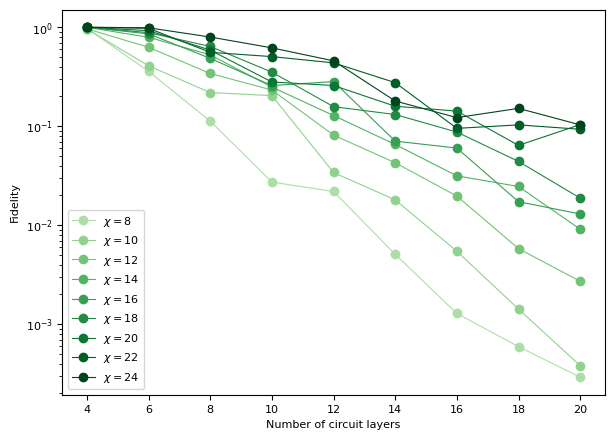

In [12]:
greens = plt.get_cmap("Greens")
plt.figure(figsize=(7, 5))
for qubits in num_qubits:
    for chi in bond_dims:
        try:
            plt.plot(
                circ_depths,
                fidelities_total[chi],
                "-o",
                label="$\chi=$" + str(chi),
                color=greens(chi / max(bond_dims)),
                linewidth=0.8,
                zorder=chi,
            )
        except:
            KeyError
plt.xticks(np.arange(4, 22, 2), fontsize=8)
plt.yticks(fontsize=8)
plt.legend(prop={"size": 8})
plt.ylabel("Fidelity", fontdict={"size": 8})
plt.xlabel("Number of circuit layers", fontdict={"size": 8})
#plt.title(str(qubits) + " qubits", fontsize=9)
plt.yscale("log")
# plt.savefig('mera_'+str(num_qubits)+'.pdf', dpi=600, bbox_inches='tight')
plt.show()